In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [2]:
# Normalize the pixel values to be between -1 and 1 (just like the PyTorch normalization you did)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


# One hot encoding the target class (labels)
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Split the original training set into 80% train and 20% test, stratifying by labels
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Now, split the new train set into 75% train and 25% validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, stratify=train_labels, random_state=42
)

# Print the shapes to verify the splits
print("Training set shape:", train_images.shape)
print("Validation set shape:", val_images.shape)
print("Test set shape:", test_images.shape)

Training set shape: (30000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


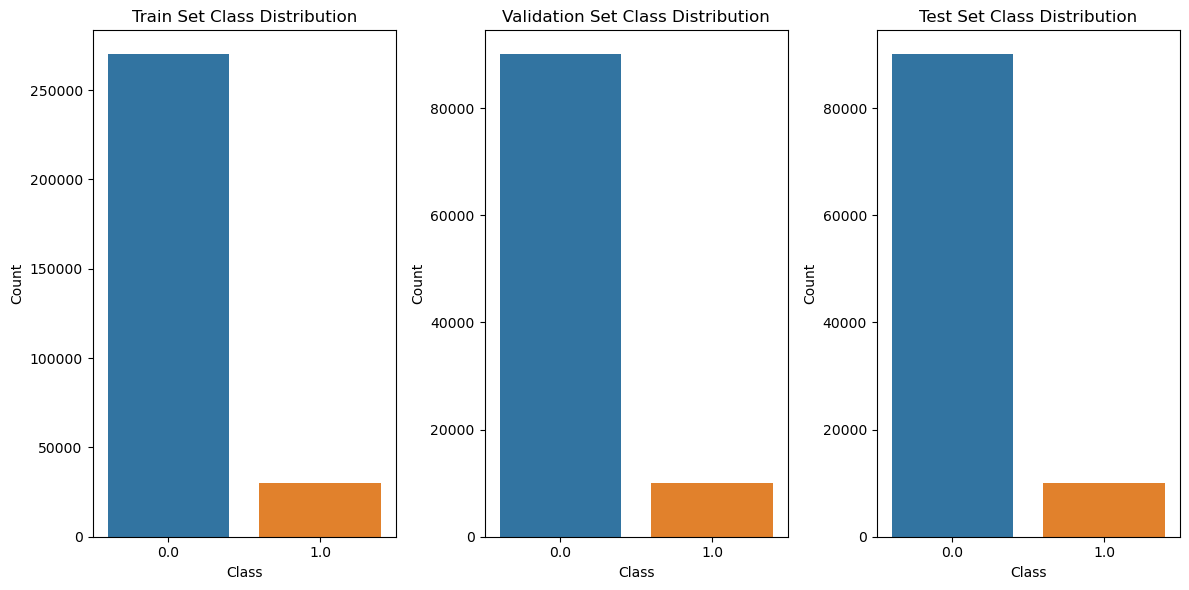

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class in the train, validation, and test sets
unique, train_counts = np.unique(train_labels, return_counts=True)
unique, val_counts = np.unique(val_labels, return_counts=True)
unique, test_counts = np.unique(test_labels, return_counts=True)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Training set distribution
plt.subplot(1, 3, 1)
sns.barplot(x=unique.flatten(), y=train_counts)
plt.title('Train Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Validation set distribution
plt.subplot(1, 3, 2)
sns.barplot(x=unique.flatten(), y=val_counts)
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Test set distribution
plt.subplot(1, 3, 3)
sns.barplot(x=unique.flatten(), y=test_counts)
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()


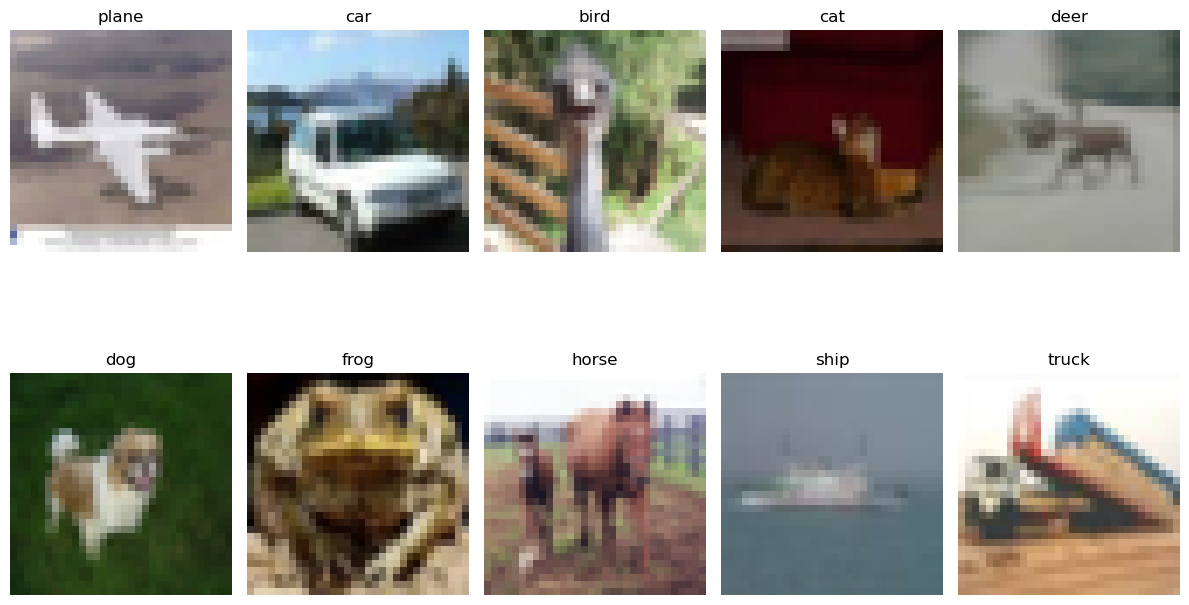

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Find and display one image from each class in the train set
plt.figure(figsize=(12, 8))

for i in range(10):
    # Get indices of all samples for the current class
    class_indices = np.where(np.argmax(train_labels, axis=1) == i)[0]  # Use np.argmax if labels are one-hot encoded
    
    # Check if there are any samples for this class
    if len(class_indices) > 0:
        idx = class_indices[0]  # Get the first index for the current class
        
        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(train_images[idx])
        plt.title(classes[i])
        plt.axis('off')
    else:
        print(f"No images found for class '{classes[i]}'")

# Show all class samples
plt.tight_layout()
plt.show()



In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x
    
    if downsample:
        # Downsample by using a convolution with stride
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Conv2D(filters, kernel_size, strides=(2, 2), padding='same')(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut (identity connection)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution and MaxPooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # ResNet stages: each has two residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)
    
    # Global Average Pooling and Dense layer for classification
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

# Define input shape and number of classes
input_shape = (32, 32, 3)  # CIFAR-10 images
num_classes = 10

# Build the ResNet-18 model
model = build_resnet18(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

Epoch 1/10


2024-10-30 07:14:12.838221: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 105s 223ms/step - loss: 1.5828 - accuracy: 0.4433 - val_loss: 1.7817 - val_accuracy: 0.3757
Epoch 2/10
469/469 [==============================] - 107s 228ms/step - loss: 1.1663 - accuracy: 0.5895 - val_loss: 2.4371 - val_accuracy: 0.2817
Epoch 3/10
469/469 [==============================] - 103s 220ms/step - loss: 0.9754 - accuracy: 0.6549 - val_loss: 1.5309 - val_accuracy: 0.4953
Epoch 4/10
469/469 [==============================] - 102s 218ms/step - loss: 0.8399 - accuracy: 0.7037 - val_loss: 1.2162 - val_accuracy: 0.5876
Epoch 5/10
469/469 [==============================] - 103s 219ms/step - loss: 0.7427 - accuracy: 0.7417 - val_loss: 1.1350 - val_accuracy: 0.6082
Epoch 6/10
469/469 [==============================] - 103s 219ms/step - loss: 0.6465 - accuracy: 0.7708 - val_loss: 1.1192 - val_accuracy: 0.6514
Epoch 7/10
469/469 [==============================] - 104s 222ms/step - loss: 0.5677 - accuracy: 0.8050 - val_loss: 0.9225 - val_accura

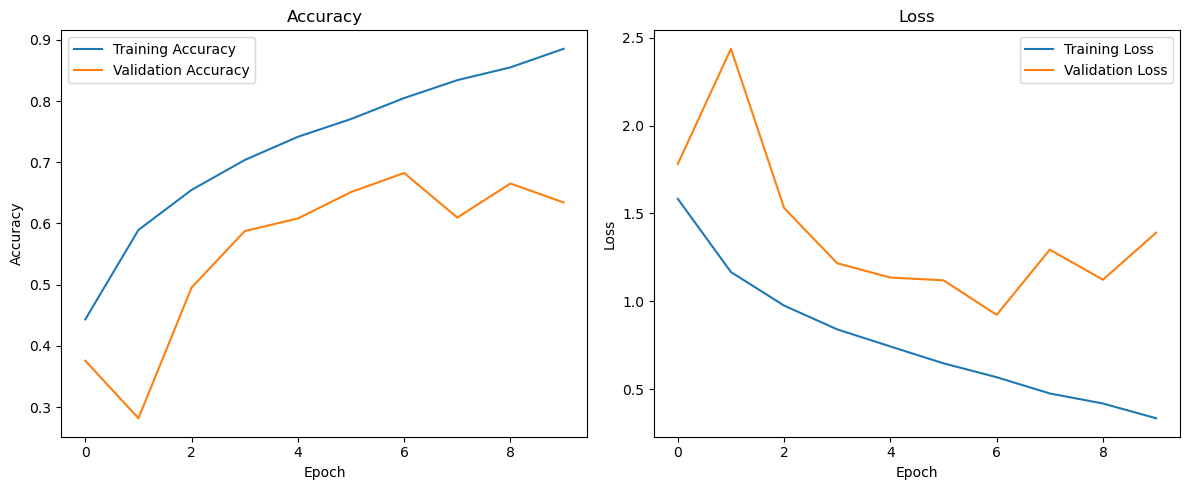

In [7]:
# Train the model using the new train and validation sets
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), batch_size=64)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Call the function to plot
plot_training_history(history)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_17 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_20[0]

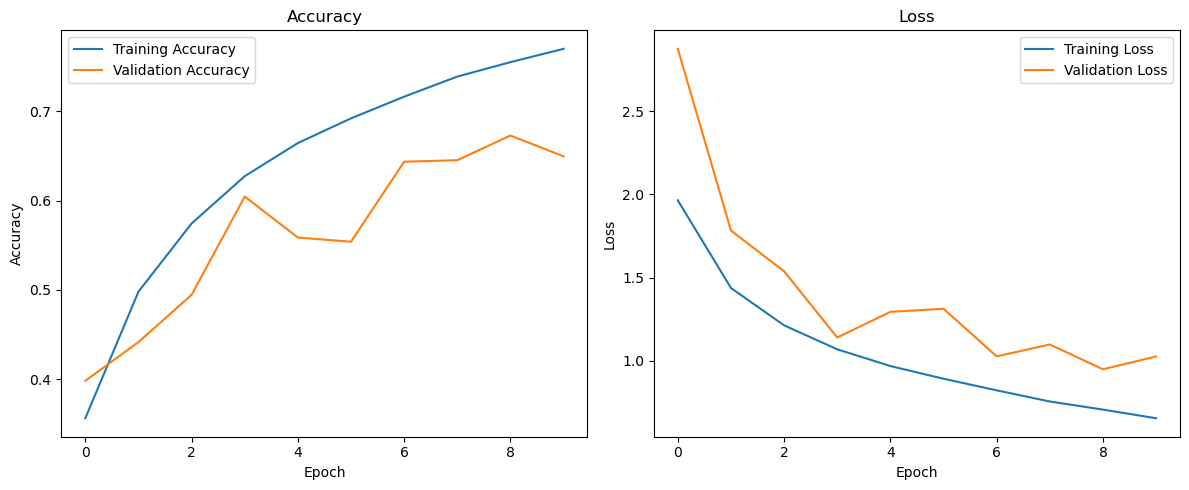

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, dropout_rate=0.3):
    shortcut = x
    
    if downsample:
        # Downsample by using a convolution with stride
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Conv2D(filters, kernel_size, strides=(2, 2), padding='same')(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Apply dropout after the first Conv layer
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut (identity connection)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

def build_resnet18(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution and MaxPooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # ResNet stages: each has two residual blocks
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    
    x = residual_block(x, 128, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 128, dropout_rate=dropout_rate)
    
    x = residual_block(x, 256, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 256, dropout_rate=dropout_rate)
    
    x = residual_block(x, 512, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 512, dropout_rate=dropout_rate)
    
    # Global Average Pooling and Dense layer for classification
    x = layers.GlobalAveragePooling2D()(x)
    
    # Additional dropout before the final dense layer
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

# Define input shape and number of classes
input_shape = (32, 32, 3)  # CIFAR-10 images
num_classes = 10

# Build the ResNet-18 model with dropout layers
model = build_resnet18(input_shape, num_classes, dropout_rate=0.3)

# Compile the model with a custom learning rate
learning_rate = 0.001
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


# Train the model using the new train and validation sets
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), batch_size=64)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

# Call the function to plot
plot_training_history(history)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_40 (Conv2D)             (None, 16, 16, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_40 (BatchN  (None, 16, 16, 64)  256         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_34 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_40[0]

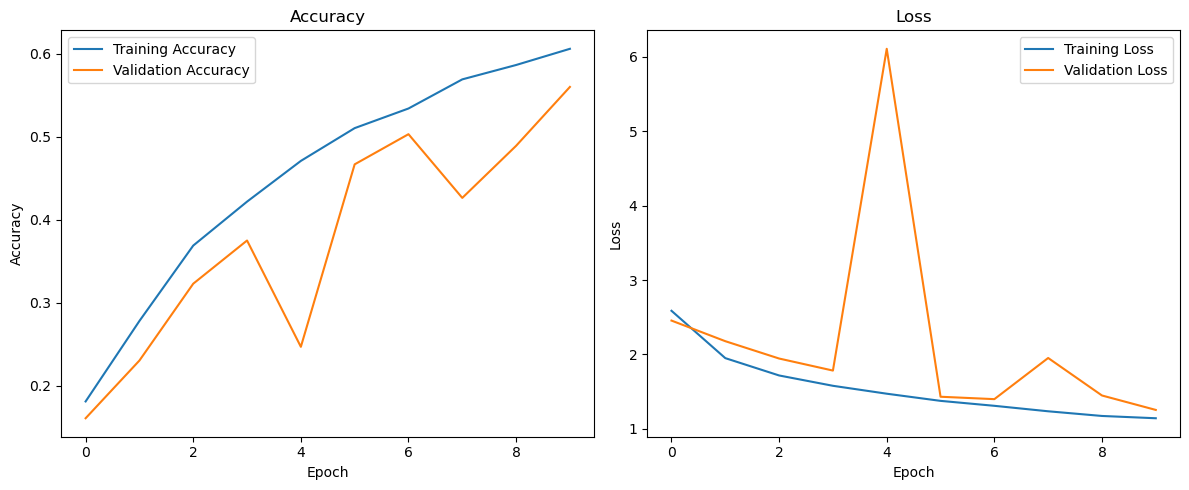

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, dropout_rate=0.3):
    shortcut = x
    
    if downsample:
        # Downsample by using a convolution with stride
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Conv2D(filters, kernel_size, strides=(2, 2), padding='same')(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Dropout after ReLU activation in the residual block
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut (identity connection)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    # Additional Dropout after the second ReLU in the residual block
    x = layers.Dropout(dropout_rate)(x)
    
    return x

def build_resnet18(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution and MaxPooling layers with added Dropout
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)  # Dropout after initial conv layer
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # ResNet stages: each has two residual blocks
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    
    x = residual_block(x, 128, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 128, dropout_rate=dropout_rate)
    
    x = residual_block(x, 256, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 256, dropout_rate=dropout_rate)
    
    x = residual_block(x, 512, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 512, dropout_rate=dropout_rate)
    
    # Global Average Pooling and Dense layer for classification
    x = layers.GlobalAveragePooling2D()(x)
    
    # Final Dropout before the dense layer
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

# Define input shape and number of classes
input_shape = (32, 32, 3)  # CIFAR-10 images
num_classes = 10

# Build the ResNet-18 model with multiple dropout layers
model = build_resnet18(input_shape, num_classes, dropout_rate=0.3)

# Compile the model with a custom learning rate
learning_rate = 0.001
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


# Train the model using the new train and validation sets
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), batch_size=64)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


# Call the function to plot
plot_training_history(history)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_60 (Conv2D)             (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_60 (BatchN  (None, 16, 16, 64)  256         ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_51 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_60[0]

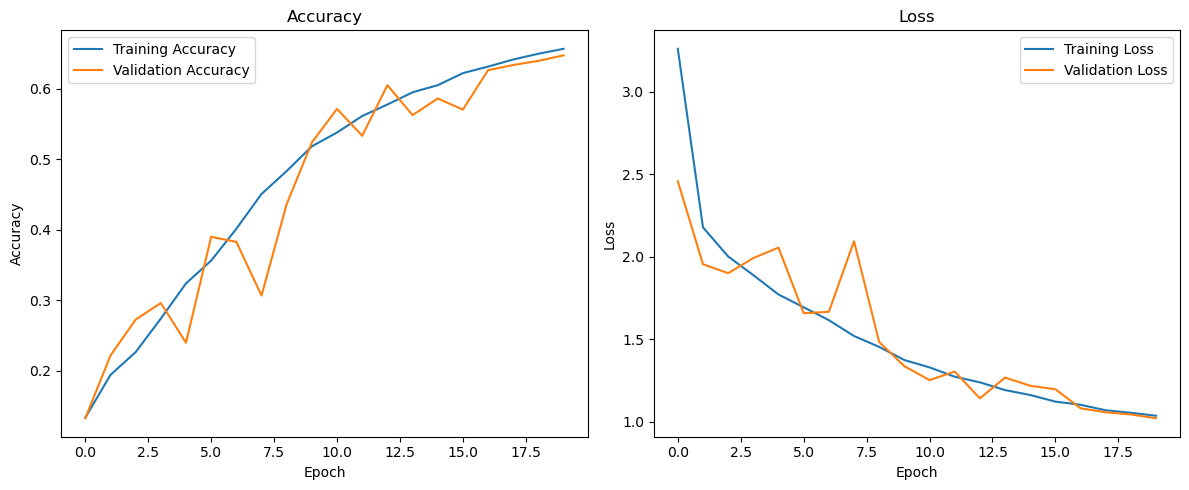

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, dropout_rate=0.3):
    shortcut = x
    if downsample:
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Conv2D(filters, kernel_size, strides=(2, 2), padding='same')(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution and pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks with increasing dropout rates
    x = residual_block(x, 64, dropout_rate=0.25)
    x = residual_block(x, 64, dropout_rate=0.25)
    
    x = residual_block(x, 128, downsample=True, dropout_rate=0.3)
    x = residual_block(x, 128, dropout_rate=0.3)
    
    x = residual_block(x, 256, downsample=True, dropout_rate=0.4)
    x = residual_block(x, 256, dropout_rate=0.4)
    
    x = residual_block(x, 512, downsample=True, dropout_rate=0.5)
    x = residual_block(x, 512, dropout_rate=0.5)
    
    # Global average pooling and dense layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Set up and compile the model
input_shape = (32, 32, 3)  # CIFAR-10 image dimensions
num_classes = 10
learning_rate = 0.001
model = build_resnet18(input_shape, num_classes)
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary to verify structure
model.summary()


# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=32
)

# Plot training history
def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_80 (Conv2D)             (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_80 (BatchN  (None, 16, 16, 64)  256         ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_68 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_80[0]

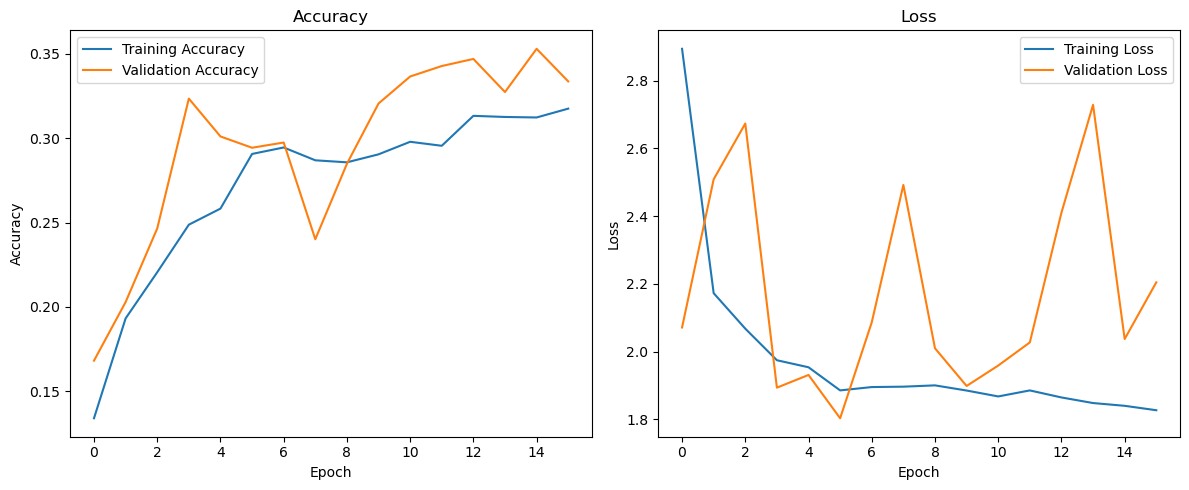

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, dropout_rate=0.3):
    shortcut = x
    if downsample:
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Conv2D(filters, kernel_size, strides=(2, 2), padding='same')(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution and pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks with increasing dropout rates
    x = residual_block(x, 64, dropout_rate=0.25)
    x = residual_block(x, 64, dropout_rate=0.25)
    
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128, dropout_rate=0.3)
    
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256, dropout_rate=0.4)
    
    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512, dropout_rate=0.5)
    
    # Global average pooling and dense layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Set up and compile the model
input_shape = (32, 32, 3)  # CIFAR-10 image dimensions
num_classes = 10
learning_rate = 0.001
model = build_resnet18(input_shape, num_classes)
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary to verify structure
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping]
)

# Plot training history
def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_266 (Conv2D)            (None, 16, 16, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_276 (Batch  (None, 16, 16, 64)  256         ['conv2d_266[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_109 (ReLU)               (None, 16, 16, 64)   0           ['batch_normalization_276[0

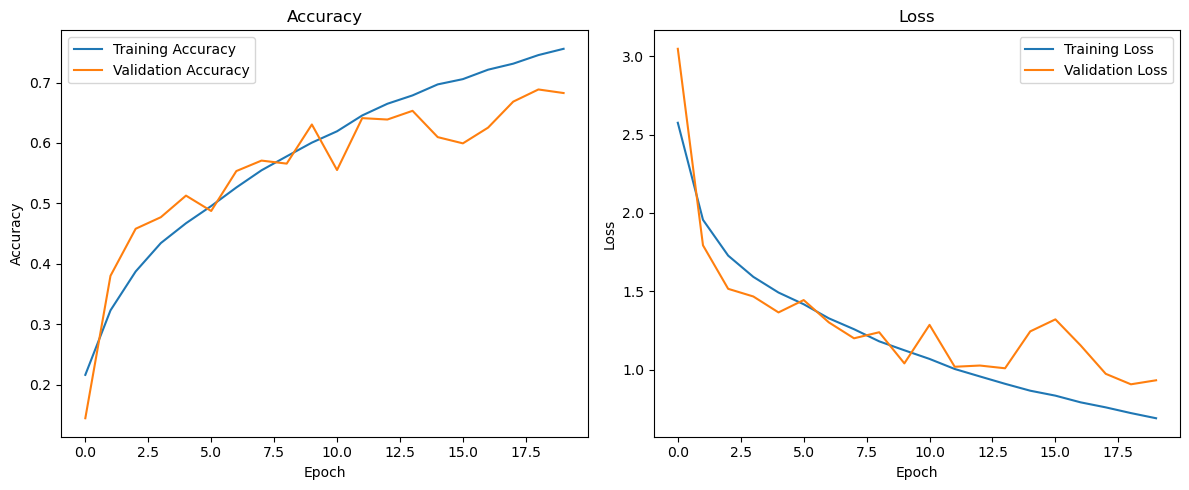

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, dropout_rate=0.3):
    shortcut = x
    
    if downsample:
        # Downsample by using a convolution with stride
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Conv2D(filters, kernel_size, strides=(2, 2), padding='same')(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Apply dropout after the first Conv layer
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut (identity connection)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

def build_resnet18(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution and MaxPooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # ResNet stages: each has two residual blocks
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    
    x = residual_block(x, 128, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 128, dropout_rate=dropout_rate)
    
    x = residual_block(x, 256, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 256, dropout_rate=dropout_rate)
    
    x = residual_block(x, 512, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 512, dropout_rate=dropout_rate)
    
    # Global Average Pooling and Dense layer for classification
    x = layers.GlobalAveragePooling2D()(x)
    
    # Additional dropout before the final dense layer
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

# Define input shape and number of classes
input_shape = (32, 32, 3)  # CIFAR-10 images
num_classes = 10

# Build the ResNet-18 model with dropout layers
model = build_resnet18(input_shape, num_classes, dropout_rate=0.3)

# Compile the model with a custom learning rate
learning_rate = 0.0001
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


# Train the model using the new train and validation sets
history = model.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), batch_size=64)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

# Call the function to plot
plot_training_history(history)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_286 (Conv2D)            (None, 16, 16, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_296 (Batch  (None, 16, 16, 64)  256         ['conv2d_286[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_126 (ReLU)               (None, 16, 16, 64)   0           ['batch_normalization_296[0

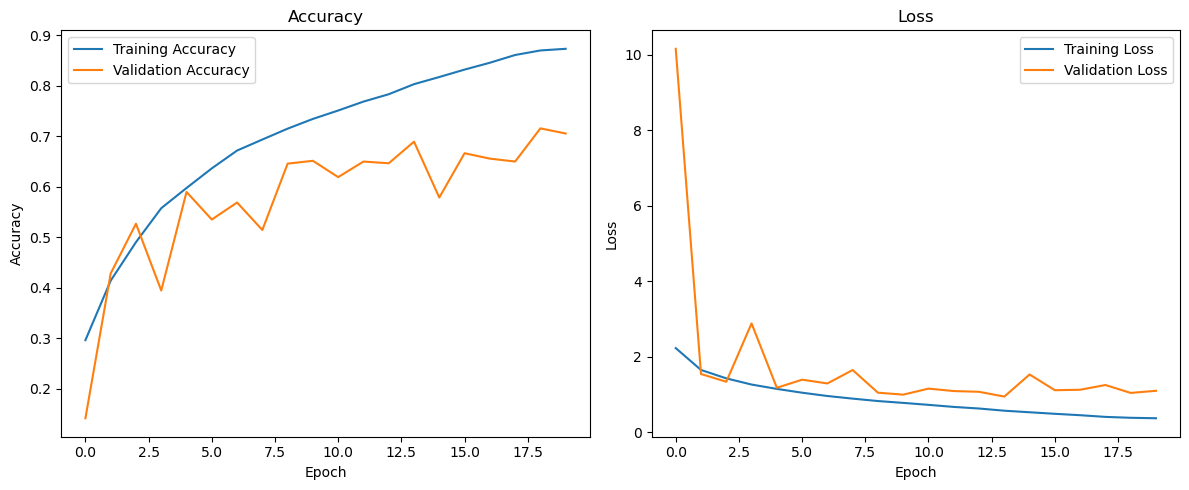

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, dropout_rate=0.3):
    shortcut = x
    
    if downsample:
        # Downsample by using a convolution with stride
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Conv2D(filters, kernel_size, strides=(2, 2), padding='same')(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Apply dropout after the first Conv layer
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut (identity connection)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

def build_resnet18(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution and MaxPooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # ResNet stages: each has two residual blocks
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    
    x = residual_block(x, 128, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 128, dropout_rate=dropout_rate)
    
    x = residual_block(x, 256, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 256, dropout_rate=dropout_rate)
    
    x = residual_block(x, 512, downsample=True, dropout_rate=dropout_rate)
    x = residual_block(x, 512, dropout_rate=dropout_rate)
    
    # Global Average Pooling and Dense layer for classification
    x = layers.GlobalAveragePooling2D()(x)
    
    # Additional dropout before the final dense layer
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

# Define input shape and number of classes
input_shape = (32, 32, 3)  # CIFAR-10 images
num_classes = 10

# Build the ResNet-18 model with dropout layers
model = build_resnet18(input_shape, num_classes, dropout_rate=0.3)

# Compile the model with a custom learning rate
learning_rate = 0.01
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


# Train the model using the new train and validation sets
history = model.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), batch_size=64)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

# Call the function to plot
plot_training_history(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 32, 32, 96)        2688      
                                                                 
 batch_normalization_100 (Ba  (None, 32, 32, 96)       384       
 tchNormalization)                                               
                                                                 
 re_lu_85 (ReLU)             (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 96)       0         
 2D)                                                             
                                                                 
 conv2d_101 (Conv2D)         (None, 16, 16, 256)       221440    
                                                                 
 batch_normalization_101 (Ba  (None, 16, 16, 256)      1

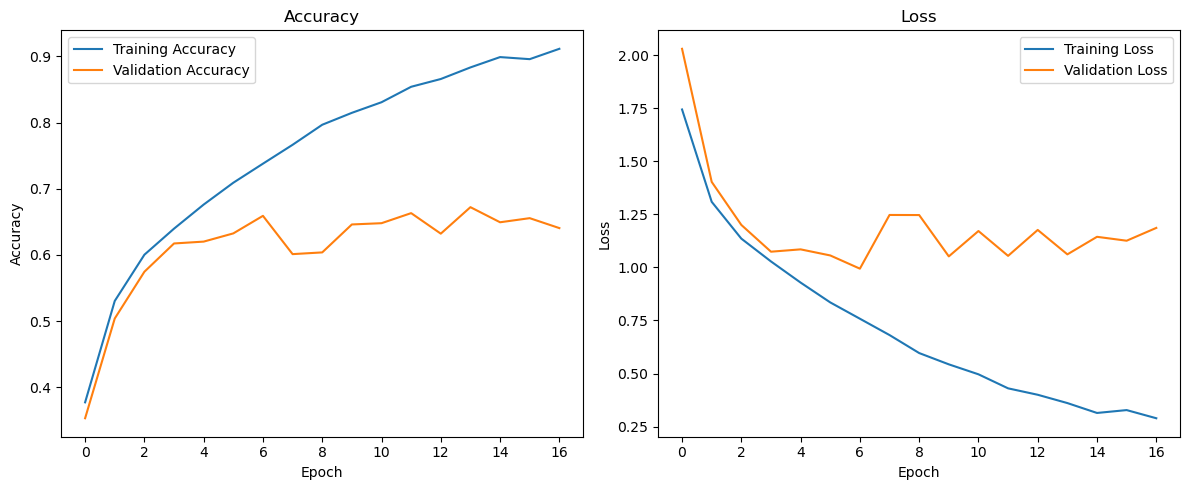

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    
    # First convolutional layer
    model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Second convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Third convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    
    # Fourth convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    
    # Fifth convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(4096))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Set up and compile the model
input_shape = (32, 32, 3)  # CIFAR-10 image dimensions
num_classes = 10
learning_rate = 0.001
model = build_alexnet(input_shape, num_classes)
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary to verify structure
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=100,
    batch_size=64,  # Increased batch size for AlexNet's larger architecture
    callbacks=[early_stopping]
)

# Plot training history
def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 32, 32, 96)        2688      
                                                                 
 batch_normalization_102 (Ba  (None, 32, 32, 96)       384       
 tchNormalization)                                               
                                                                 
 re_lu_91 (ReLU)             (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 96)       0         
 2D)                                                             
                                                                 
 conv2d_106 (Conv2D)         (None, 16, 16, 256)       221440    
                                                                 
 batch_normalization_103 (Ba  (None, 16, 16, 256)     

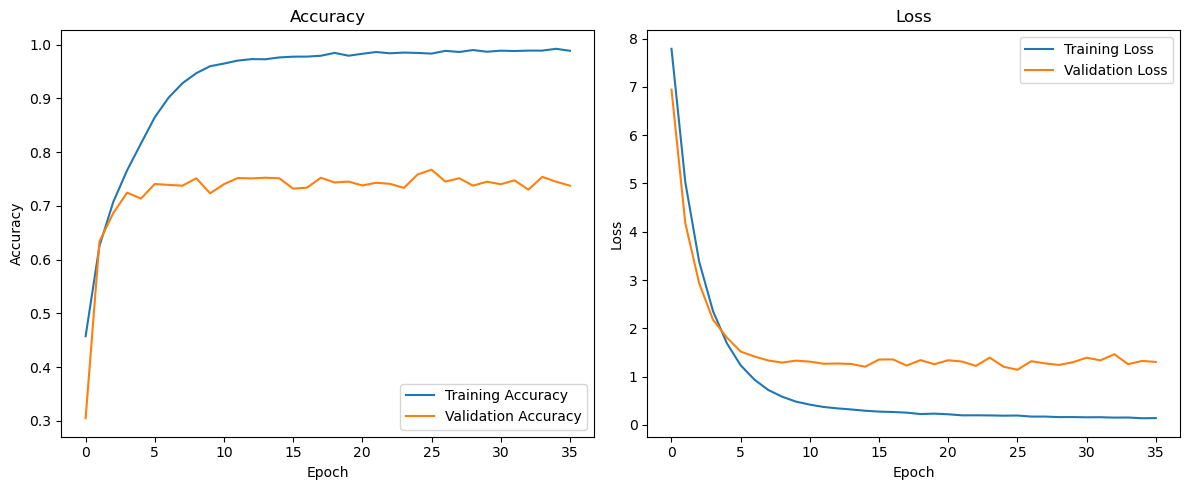

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
import matplotlib.pyplot as plt

def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    
    # First convolutional layer
    model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Second convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Third convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    
    # Fourth convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    
    # Fifth convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Flatten and fully connected layers with L2 regularization
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Set up and compile the model
input_shape = (32, 32, 3)  # CIFAR-10 image dimensions
num_classes = 10
learning_rate = 0.0001  # Reduced learning rate
model = build_alexnet(input_shape, num_classes)
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary to verify structure
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=100,
    batch_size=64,  # Increased batch size for AlexNet's larger architecture
    callbacks=[early_stopping]
)

# Plot training history
def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 32, 32, 96)        2688      
                                                                 
 batch_normalization_104 (Ba  (None, 32, 32, 96)       384       
 tchNormalization)                                               
                                                                 
 re_lu_97 (ReLU)             (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 96)       0         
 g2D)                                                            
                                                                 
 dropout_67 (Dropout)        (None, 16, 16, 96)        0         
                                                                 
 conv2d_111 (Conv2D)         (None, 16, 16, 256)      

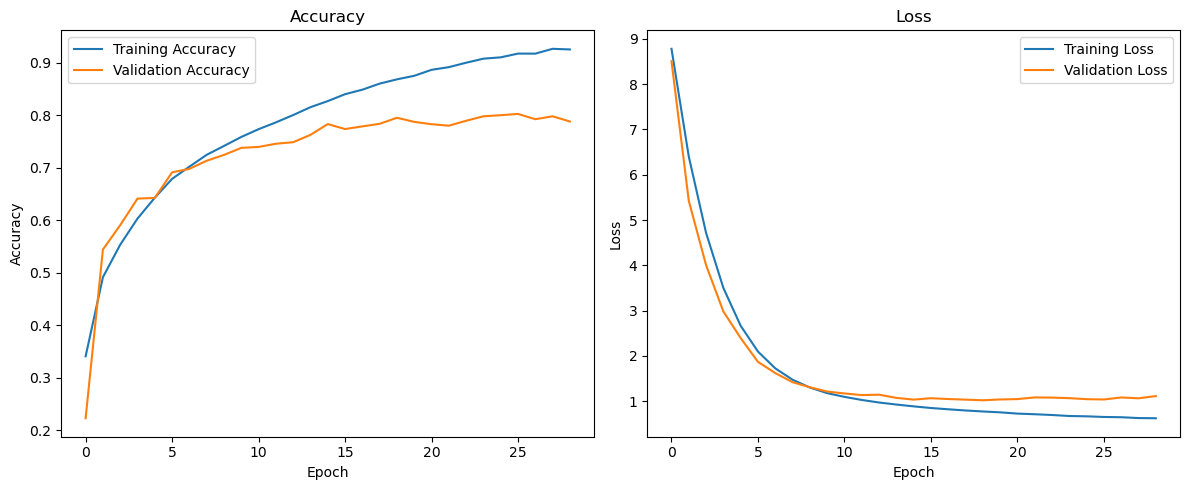

In [14]:
from tensorflow.keras import layers, models, regularizers

def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    
    # First convolutional layer
    model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))  # Added Dropout layer

    # Second convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))  # Added Dropout layer

    # Third convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))  # Added Dropout layer

    # Fourth convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))  # Added Dropout layer

    # Fifth convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))  # Added Dropout layer

    # Flatten and fully connected layers with L2 regularization
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model


# Set up and compile the model
input_shape = (32, 32, 3)  # CIFAR-10 image dimensions
num_classes = 10
learning_rate = 0.0001  # Reduced learning rate
model = build_alexnet(input_shape, num_classes)
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary to verify structure
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=100,
    batch_size=64,  # Increased batch size for AlexNet's larger architecture
    callbacks=[early_stopping]
)

# Plot training history
def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_115 (Conv2D)         (None, 32, 32, 96)        2688      
                                                                 
 batch_normalization_106 (Ba  (None, 32, 32, 96)       384       
 tchNormalization)                                               
                                                                 
 re_lu_103 (ReLU)            (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 96)       0         
 g2D)                                                            
                                                                 
 dropout_74 (Dropout)        (None, 16, 16, 96)        0         
                                                                 
 conv2d_116 (Conv2D)         (None, 16, 16, 256)      

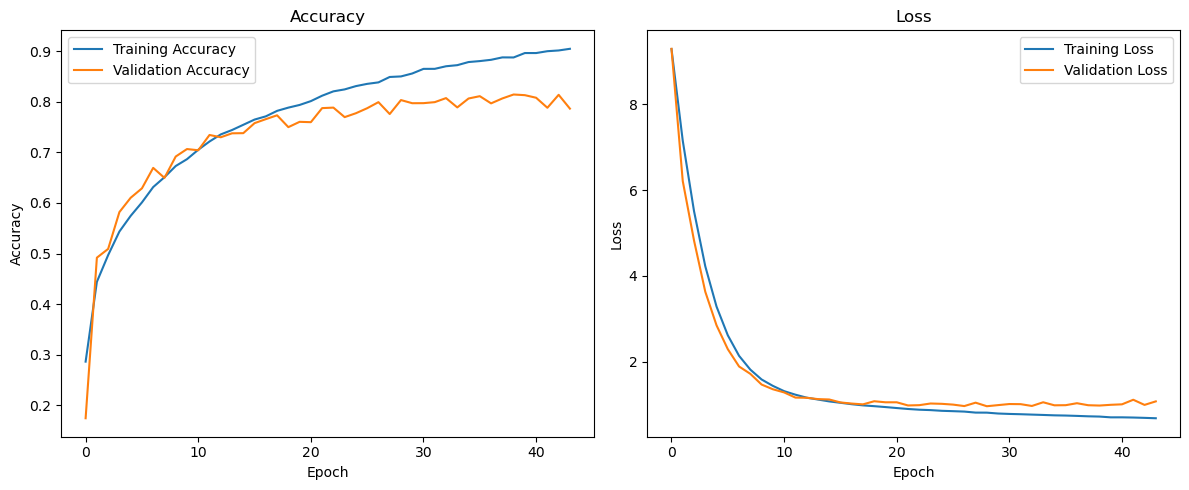

In [15]:
from tensorflow.keras import layers, models, regularizers

def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    
    # First convolutional layer
    model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))  # Added Dropout layer

    # Second convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.3))  # Added Dropout layer

    # Third convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.35))  # Added Dropout layer

    # Fourth convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.4))  # Added Dropout layer

    # Fifth convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.45))  # Added Dropout layer

    # Flatten and fully connected layers with L2 regularization
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model


# Set up and compile the model
input_shape = (32, 32, 3)  # CIFAR-10 image dimensions
num_classes = 10
learning_rate = 0.0001  # Reduced learning rate
model = build_alexnet(input_shape, num_classes)
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary to verify structure
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=64,  # Increased batch size for AlexNet's larger architecture
    callbacks=[early_stopping]
)

# Plot training history
def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

In [16]:
#Initial Model

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=10, 
    validation_data=(val_images, val_labels), 
    batch_size=8
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_108 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_121 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_109 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [17]:
#Model 2

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    validation_data=(val_images, val_labels), 
    batch_size=16
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_126 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_115 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_127 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_116 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [18]:
#Model 3

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    validation_data=(val_images, val_labels), 
    batch_size=16
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_122 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_133 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_123 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [19]:
#Model 4

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=50, 
    validation_data=(val_images, val_labels), 
    batch_size=32
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_138 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_129 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_139 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_130 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [20]:
#Model 5

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=50, 
    validation_data=(val_images, val_labels), 
    batch_size=64
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_136 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_145 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_137 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [21]:
#Model 6

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=50, 
    validation_data=(val_images, val_labels), 
    batch_size=32
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_150 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_143 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_151 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_144 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

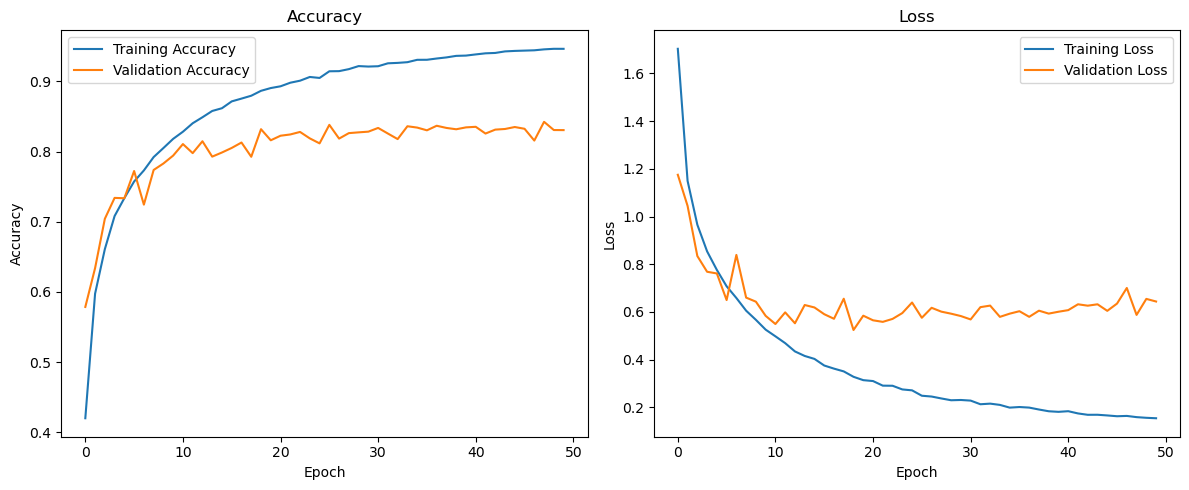

In [22]:
def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_156 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_150 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_157 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_151 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

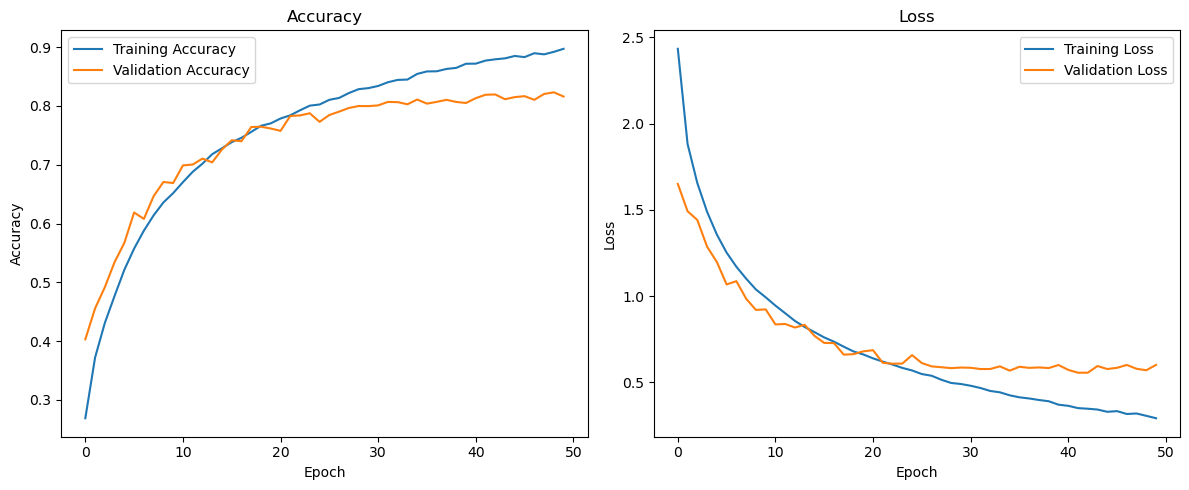

In [23]:
#Model 7

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=50, 
    validation_data=(val_images, val_labels), 
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


# Call the function to plot
plot_training_history(history)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_157 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_163 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_158 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

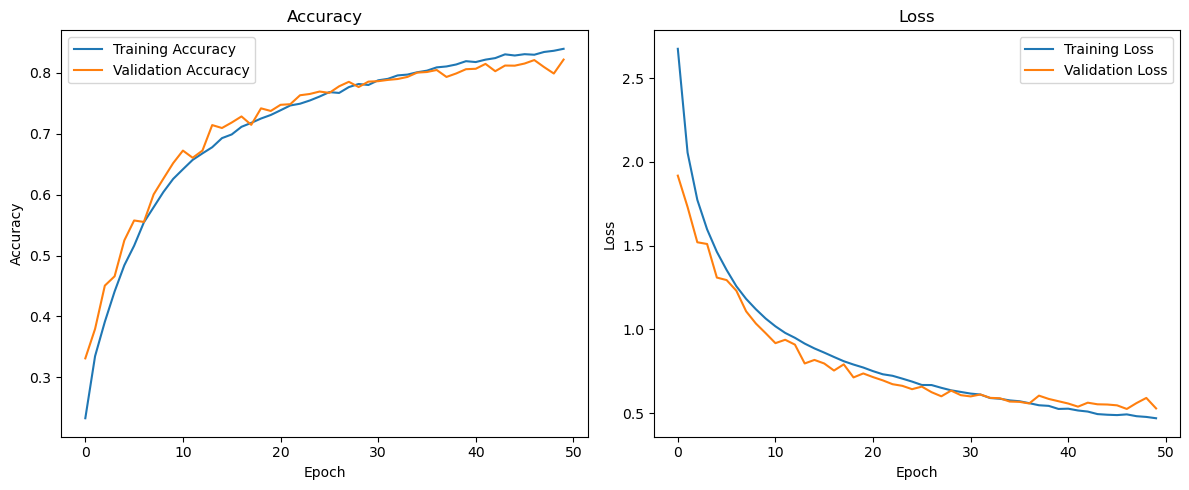

In [24]:
#Model 8

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), ## This helps to reduce overfitting
tf.keras.layers.Dense(10, activation='softmax') # num_classes = 10
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=50, 
    validation_data=(val_images, val_labels), 
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")




plot_training_history(history)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_306 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_316 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_307 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_317 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

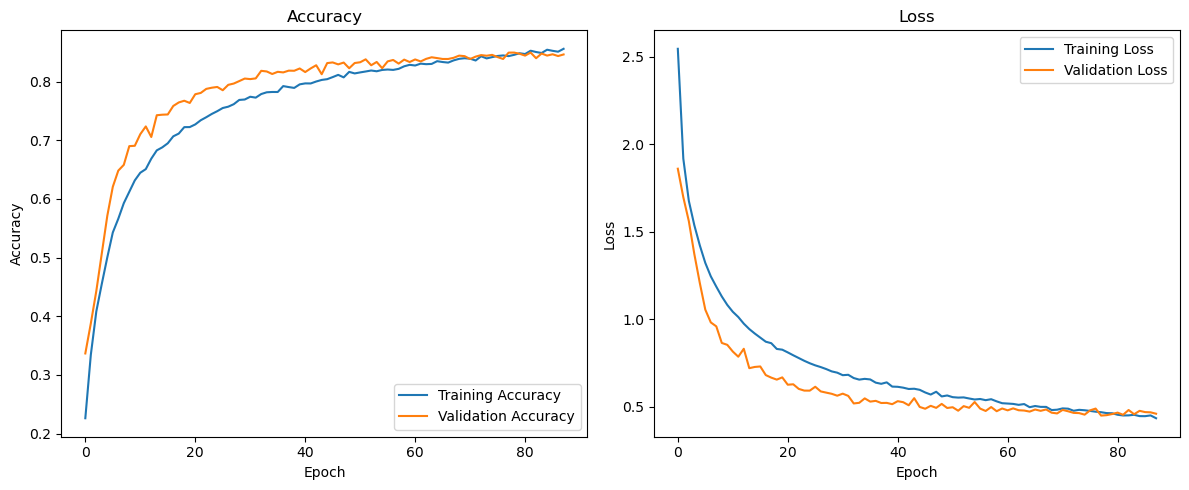

In [49]:
#Model 9

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
               loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_174 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_171 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_175 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_172 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

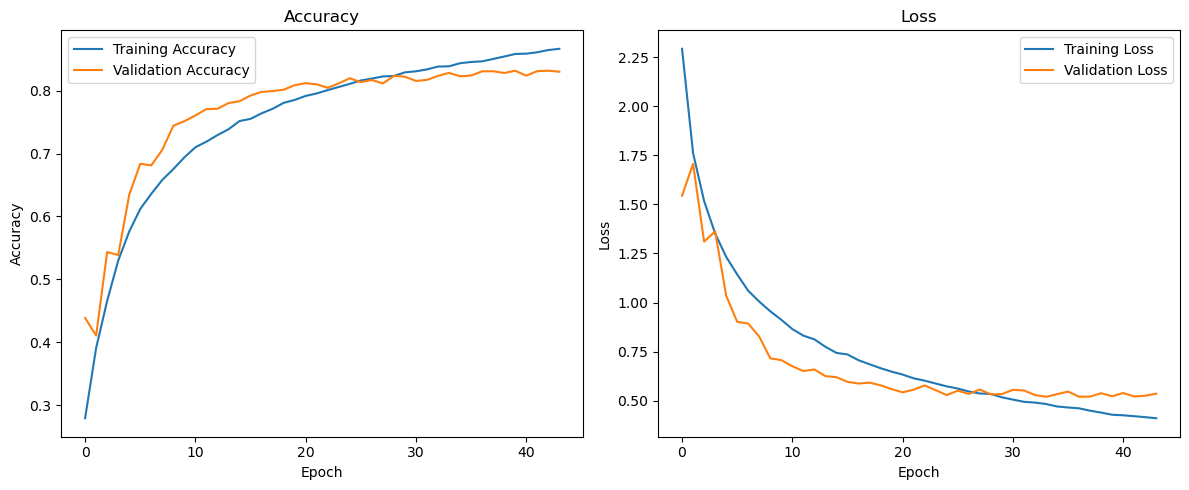

In [26]:
#Model 10

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])


# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


plot_training_history(history)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_180 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_178 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_181 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_179 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

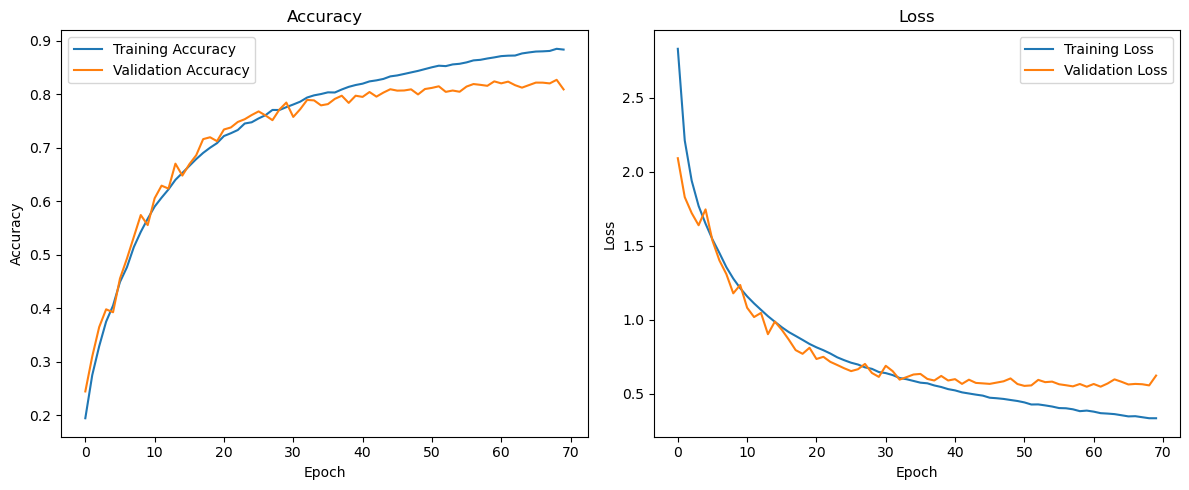

In [27]:
#Model 11

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_187 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_189 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_188 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

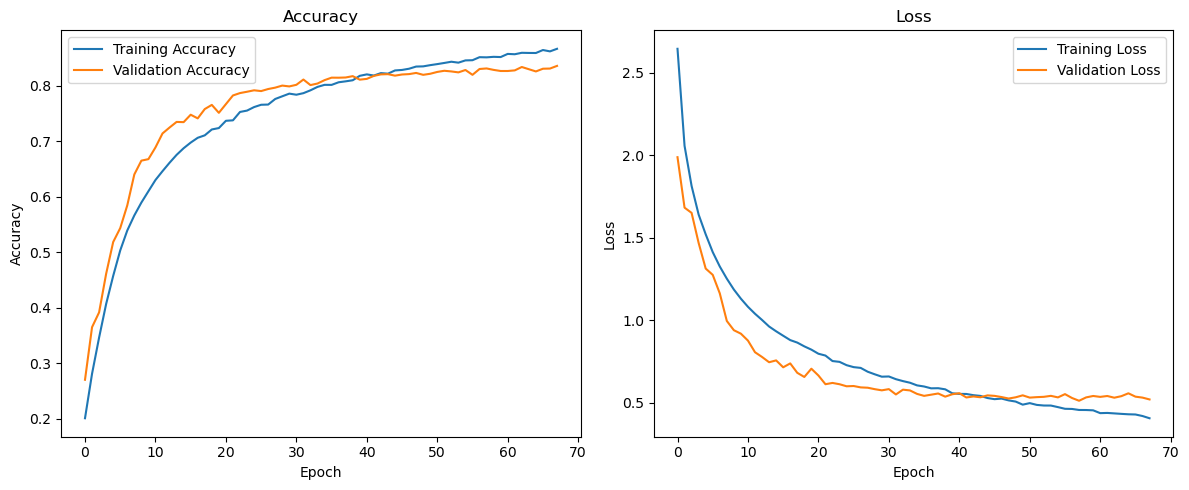

In [28]:
#Model 12

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax')
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


plot_training_history(history)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_196 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_196 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_197 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_197 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

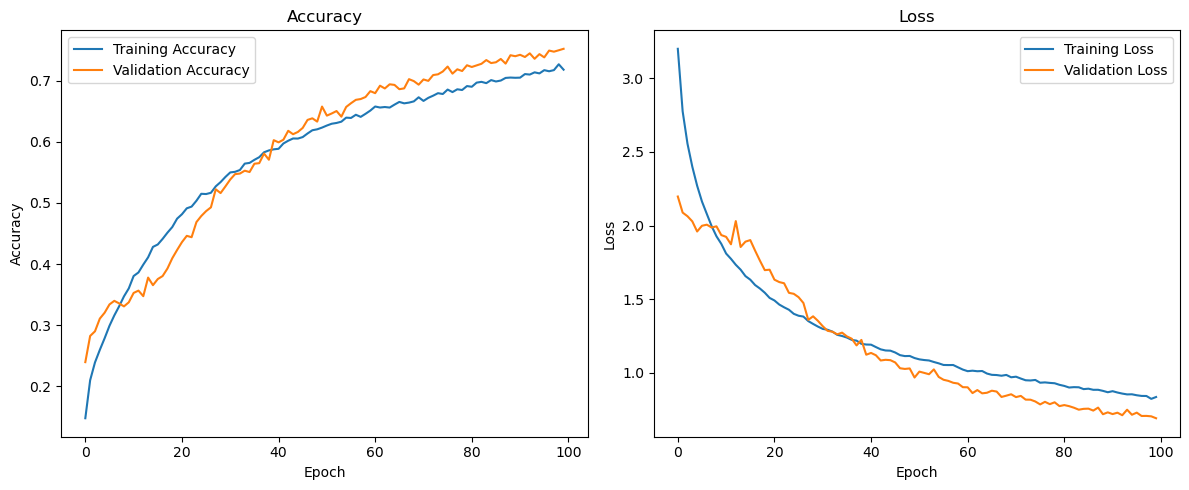

In [29]:
#Model 13

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),


tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_202 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_203 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_203 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_204 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

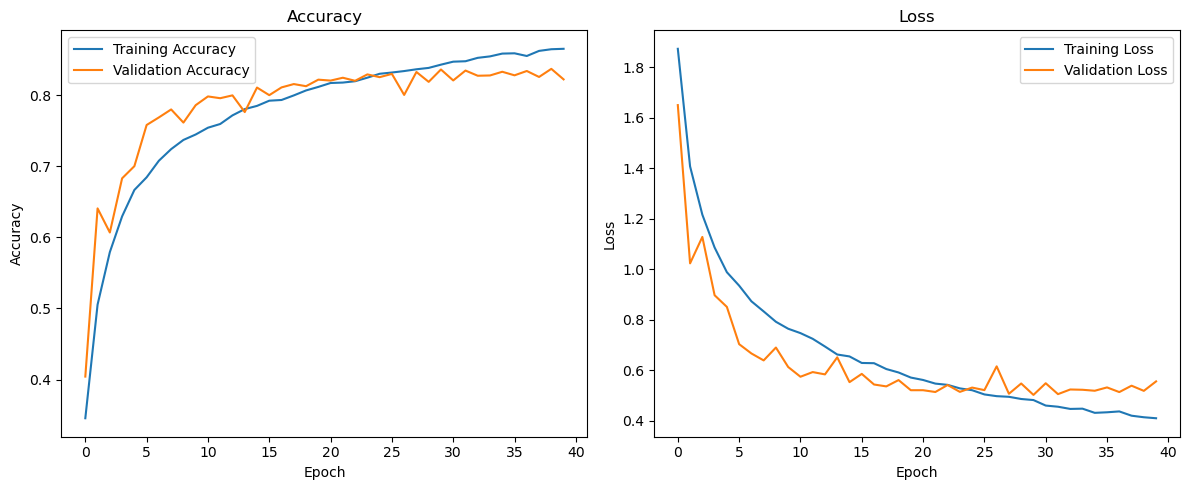

In [30]:
#Model 14

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),


tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_208 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_210 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_209 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_211 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

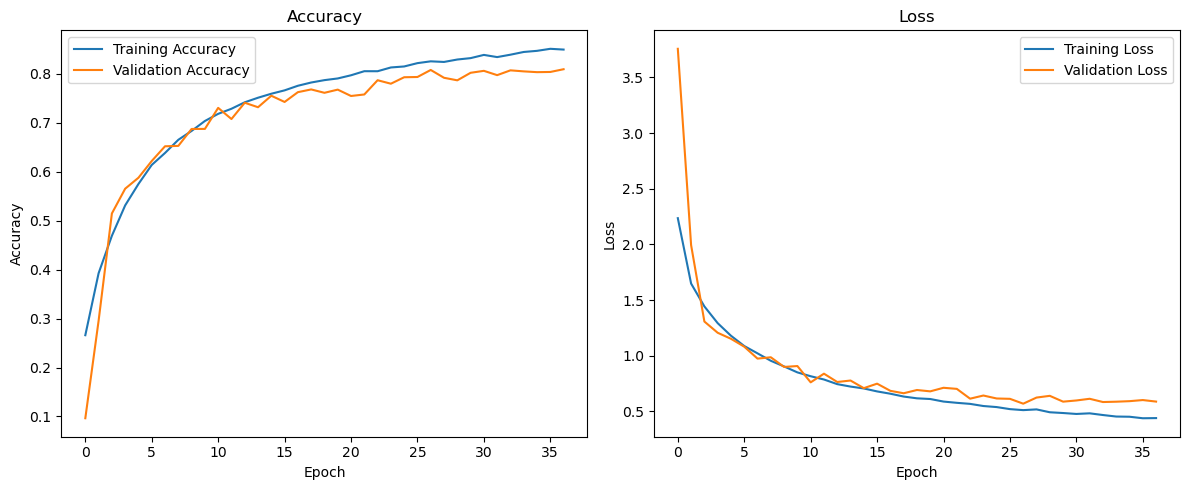

In [31]:
#model 15

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=128,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_216 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_219 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_217 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_220 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

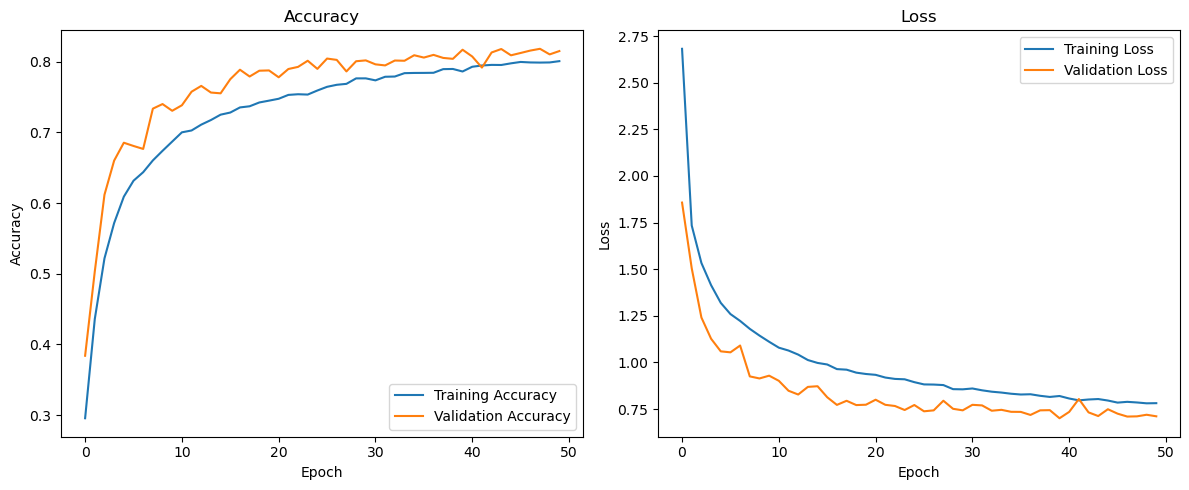

In [32]:
#Model 16

from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_224 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_228 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_225 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_229 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

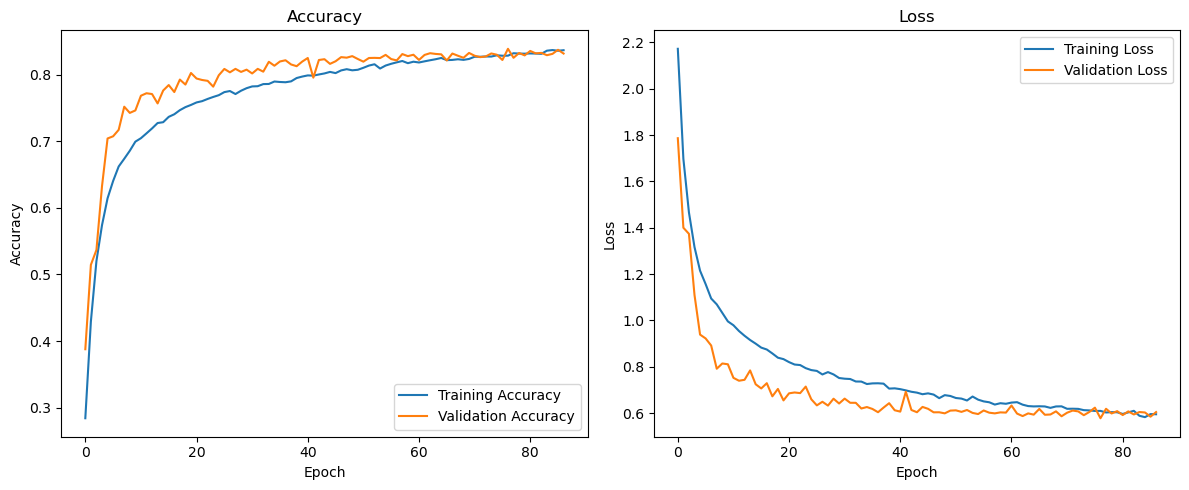

In [33]:
#Model 17

from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_232 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_237 (Ba  (None, 32, 32, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_233 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_238 (Ba  (None, 32, 32, 16)       64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                     

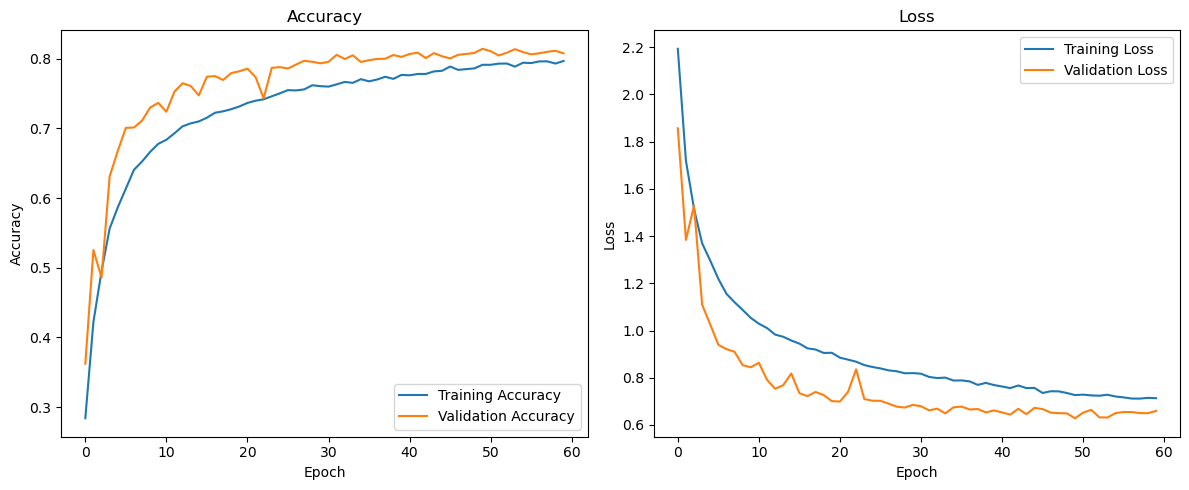

In [34]:
#Model 18 

from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_240 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_246 (Ba  (None, 32, 32, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_241 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_247 (Ba  (None, 32, 32, 16)       64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                     

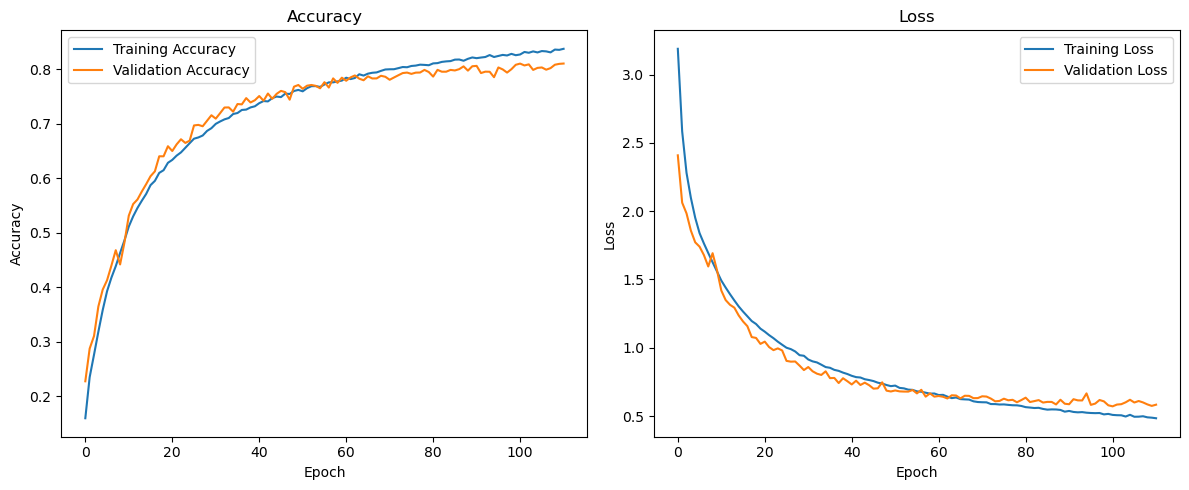

In [35]:
#Model 19

from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model.summary()


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history = model.fit(
    train_images, 
    train_labels, 
    epochs=200, 
    validation_data=(val_images, val_labels), 
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history)

313/313 [==============================] - 2s 6ms/step


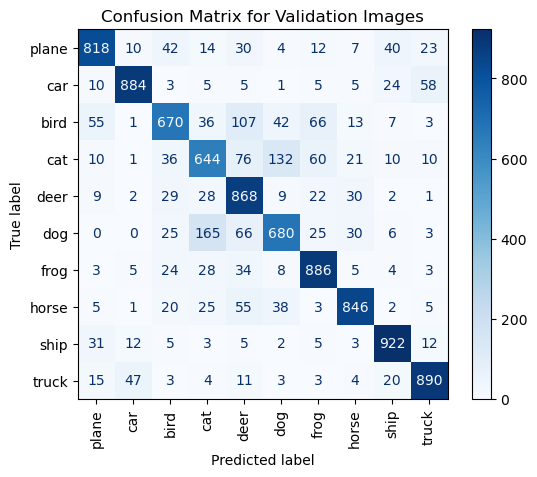

In [39]:


# Define class names (replace with actual class names in your dataset)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Make predictions on the validation set
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)  # Convert probabilities to class labels
true_val_labels = np.argmax(val_labels, axis=1)       # Convert one-hot labels to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_val_labels, val_pred_labels)

# Plot the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Validation Images")
plt.show()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_320 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_332 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_321 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_333 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

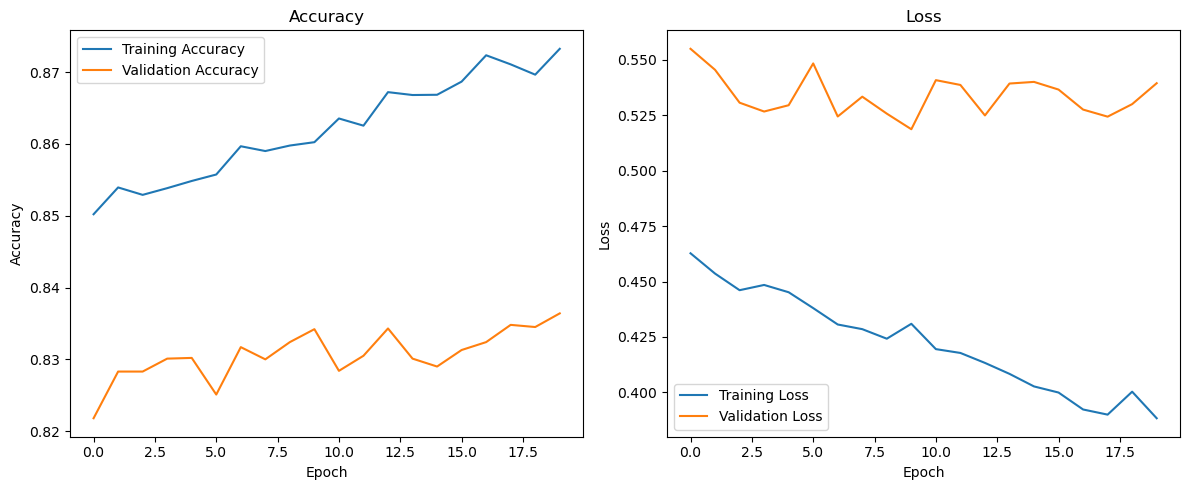

313/313 [==============================] - 3s 11ms/step


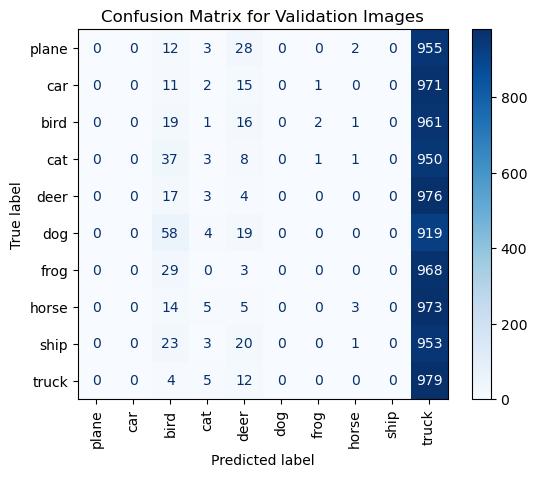

In [51]:
# Retrain and complete Confusion matrix on 3 best models based on Train and Val Accuracy

#Model 9

model9 = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.5),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model9.summary()


# Compile the model
model9.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
               loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history9 = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model9.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history9)


# Define class names (replace with actual class names in your dataset)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Make predictions on the validation set
val_predictions = model9.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)  # Convert probabilities to class labels
true_val_labels = np.argmax(val_labels, axis=1)       # Convert one-hot labels to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_val_labels, val_pred_labels)

# Plot the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Validation Images")
plt.show()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_312 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_323 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_313 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_324 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

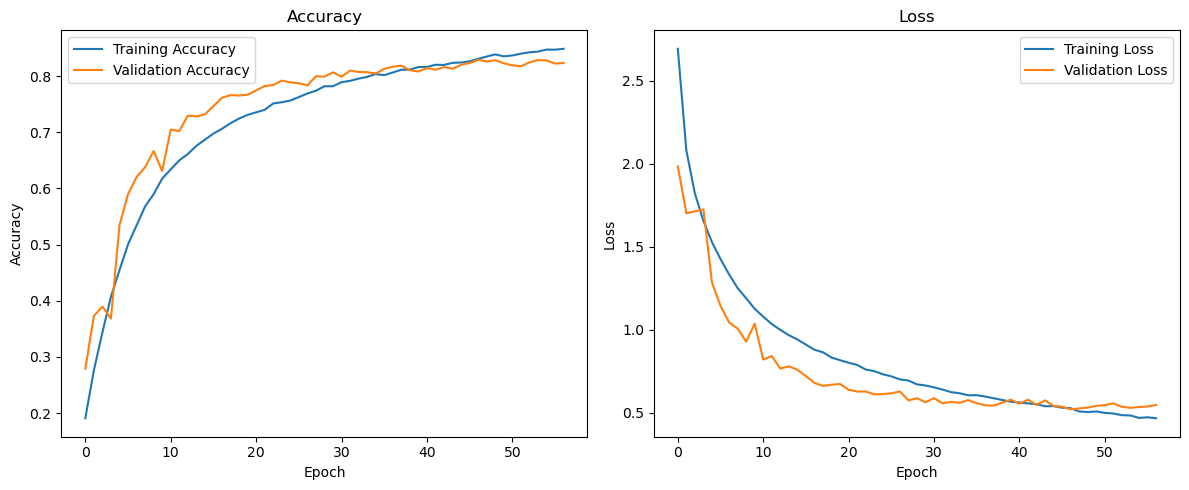

313/313 [==============================] - 3s 10ms/step


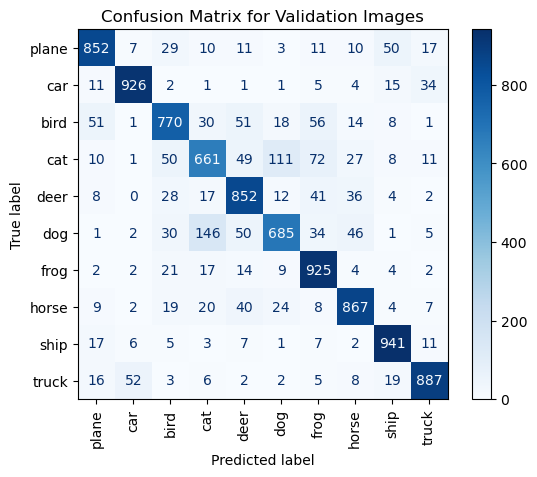

In [50]:
#2nd model to review and retrain for best model prior to Test data.

model12 = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax')
])    

# Checking the model summary
model12.summary()


# Compile the model
model12.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history12 = model.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model12.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")


plot_training_history(history12)


# Define class names (replace with actual class names in your dataset)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Make predictions on the validation set
val_predictions = model12.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)  # Convert probabilities to class labels
true_val_labels = np.argmax(val_labels, axis=1)       # Convert one-hot labels to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_val_labels, val_pred_labels)

# Plot the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Validation Images")
plt.show()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_260 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_269 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_261 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_270 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

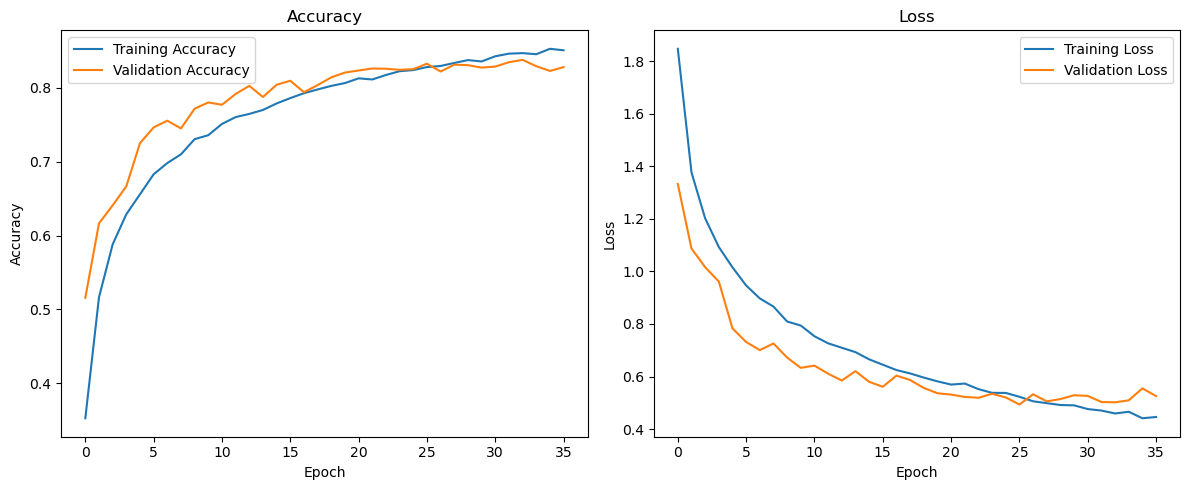

In [42]:
#3rd model to review and retrain for best model prior to Test data.

model17 = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.25),


tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.35),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5), 
tf.keras.layers.Dense(10, activation='softmax') 
])    

# Checking the model summary
model17.summary()


# Compile the model
model17.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model using the new train and validation sets
history17 = model17.fit(
    train_images, 
    train_labels, 
    epochs=100, 
    validation_data=(val_images, val_labels), 
    batch_size=8,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model17.evaluate(val_images, val_labels)
print(f"Validation accuracy: {val_acc}")

plot_training_history(history17)

313/313 [==============================] - 4s 12ms/step


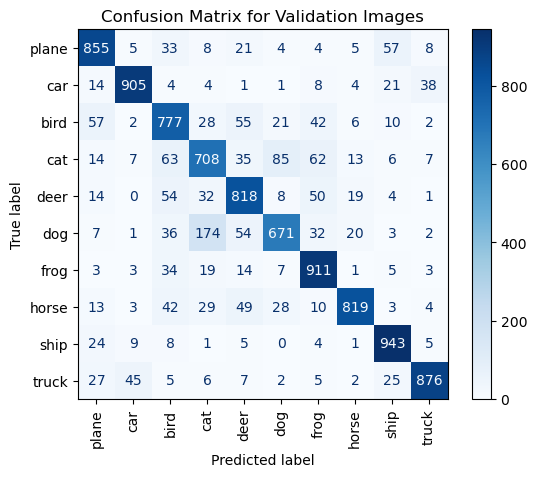

In [44]:
# Define class names (replace with actual class names in your dataset)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Make predictions on the validation set
val_predictions = model17.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)  # Convert probabilities to class labels
true_val_labels = np.argmax(val_labels, axis=1)       # Convert one-hot labels to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_val_labels, val_pred_labels)

# Plot the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Validation Images")
plt.show()

313/313 [==============================] - 4s 11ms/step - loss: 0.5145 - accuracy: 0.8368
Test accuracy: 0.8367999792098999
313/313 [==============================] - 4s 12ms/step


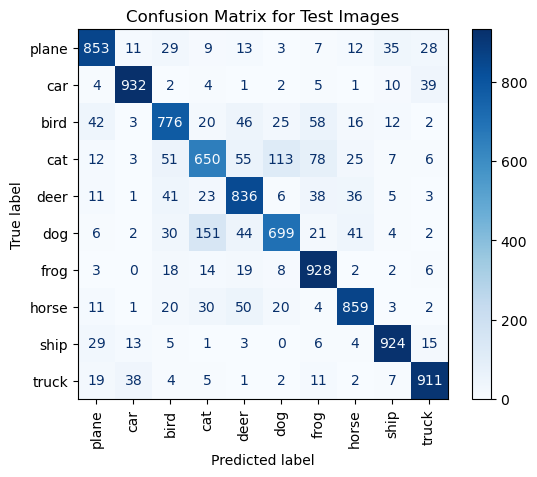

In [45]:
# Evaluate the model on the test set
test_loss, test_acc = model12.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

# Make predictions on the test set
test_predictions = model12.predict(test_images)
test_pred_labels = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels
true_test_labels = np.argmax(test_labels, axis=1)       # Convert one-hot labels to class labels

# Generate confusion matrix for test data
test_conf_matrix = confusion_matrix(true_test_labels, test_pred_labels)

# Plot the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Test Images")
plt.show()


In [46]:
# Calculate per-label accuracy
label_accuracies = test_conf_matrix.diagonal() / test_conf_matrix.sum(axis=1)
label_accuracies_percent = label_accuracies * 100  # Convert to percentage

# Display the label accuracies with class names
print("Accuracy per label:")
for label, accuracy in zip(class_names, label_accuracies_percent):
    print(f"{label}: {accuracy:.2f}%")


Accuracy per label:
plane: 85.30%
car: 93.20%
bird: 77.60%
cat: 65.00%
deer: 83.60%
dog: 69.90%
frog: 92.80%
horse: 85.90%
ship: 92.40%
truck: 91.10%
